# Possible New Geometry - Cropped Image

With geom_crop(), you can fill polygons with any raster images loaded from a URL.

To run the notebook, you need to log in on [pixabay.com](https://pixabay.com) and get the API key from [here](https://pixabay.com/api/docs).

In [1]:
import requests

import pandas as pd
import geopandas as gpd
import shapely

from lets_plot import *

from geoms.crop import geom_crop

In [2]:
LetsPlot.setup_html()

## Preparation

In [3]:
pixabay_api_key = input('Type your API key: ')

Type your API key:  16507001-dbfe4745c6efe7d02a7a460ce


In [4]:
def get_naturalearth_data(data_type="admin_0_countries", columns=["NAME", "geometry"]):
    import shapefile
    from shapely.geometry import shape

    naturalearth_url = "https://raw.githubusercontent.com/JetBrains/lets-plot-docs/master/" + \
                       "data/naturalearth/{0}/data.shp?raw=true".format(data_type)
    sf = shapefile.Reader(naturalearth_url)

    gdf = gpd.GeoDataFrame(
        [
            dict(zip([field[0] for field in sf.fields[1:]], record))
            for record in sf.records()
        ],
        geometry=[shape(s) for s in sf.shapes()]
    )[columns]
    gdf.columns = [col.lower() for col in gdf.columns]

    return gdf

In [5]:
def project_geometry(gdf, geometry, *, proj, new_width, new_height):
    gdf = gdf.to_crs(proj)
    origin = (gdf.total_bounds[0], gdf.total_bounds[1])
    gdf[geometry] = gdf[geometry].apply(lambda geom: shapely.affinity.translate(geom, \
                                                                                xoff=-origin[0], \
                                                                                yoff=-origin[1]))
    current_width = gdf.total_bounds[2] - gdf.total_bounds[0]
    current_height = gdf.total_bounds[3] - gdf.total_bounds[1]
    gdf[geometry] = gdf[geometry].apply(lambda geom: shapely.affinity.scale(geom, \
                                                                            xfact=new_width / current_width, \
                                                                            yfact=new_height / current_height, \
                                                                            origin=(0, 0)))
    gdf[geometry] = gdf[geometry].apply(lambda geom: shapely.wkt.loads(shapely.wkt.dumps(geom, rounding_precision=0)))
    return gdf

In [6]:
def get_europe_gdf(*, original_proj):
    world_gdf = get_naturalearth_data()
    world_gdf.crs = original_proj
    europe_bb = gpd.GeoDataFrame(geometry=[shapely.geometry.box(-10, 70, 40, 30)], crs=original_proj)
    return gpd.overlay(world_gdf, europe_bb, how='intersection')

In [7]:
def get_projected_europe_gdf(*, width, height):
    europe_gdf = get_europe_gdf(original_proj='epsg:4326')
    europe_gdf = project_geometry(europe_gdf, 'geometry', proj='epsg:3857', new_width=width, new_height=height)
    europe_gdf = europe_gdf[~europe_gdf.geometry.isna()]
    europe_gdf.geometry = europe_gdf.geometry.apply(lambda geom: geom if geom.is_valid else geom.convex_hull)
    return europe_gdf

In [8]:
def point_to_df(geom, *, name):
    return pd.DataFrame(dict(x=[geom.x], y=[geom.y], name=[name], index=[0]))

def polygon_to_df(geom, *, name, index=0):
    x, y = list(zip(*geom.exterior.coords))
    return pd.DataFrame(dict(x=x, y=y, name=[name] * len(x), index=[index] * len(x)))

def multipolygon_to_df(multipolygon, *, name):
    return pd.concat([polygon_to_df(polygon, name=name, index=index) for index, polygon in enumerate(multipolygon.geoms)])

def geom_to_df(geom, *, name):
    if geom.geom_type == 'Point':
        return point_to_df(geom, name=name)
    elif geom.geom_type == 'Polygon':
        return polygon_to_df(geom, name=name)
    elif geom.geom_type == 'MultiPolygon':
        return multipolygon_to_df(geom, name=name)
    else:
        return pd.DataFrame(dict(x=[], y=[], name=[], index=[]))

def gdf_to_df(gdf):
    df = pd.concat([geom_to_df(row['geometry'], name=row['name']) for i, row in gdf.iterrows()])
    return df.reset_index(drop=True)

In [9]:
def get_image_url(country, *, category):
    query = country
    request_url = 'https://pixabay.com/api/?key={api_key}&category={category}&q={query}'.format(
        api_key=pixabay_api_key,
        category=category,
        query=query.replace(' ', '+')
    )
    hits = requests.get(request_url).json().get('hits')
    if hits and len(hits) > 0:
        return hits[0]['largeImageURL']
    else:
        return ''

In [10]:
def construct_images_df(countries_df, *, category, column_name=None):
    images_df = countries_df.copy()
    column_name = column_name or '%s_img' % category
    images_df[column_name] = countries_df.iloc[:, 0].apply(get_image_url, category=category)
    return images_df

## Let's Plot!

In [11]:
width, height = 450, 600

In [12]:
europe_gdf = get_projected_europe_gdf(width=width, height=height)
europe_gdf = europe_gdf.merge(construct_images_df(europe_gdf[['name']], category='nature'), on='name')
europe_gdf = europe_gdf.merge(construct_images_df(europe_gdf[['name']], category='buildings'), on='name')

WARN: The function color() is deprecated and is no longer supported.



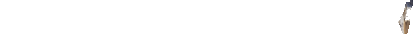
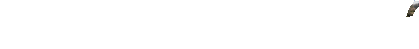
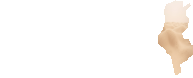
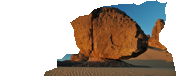
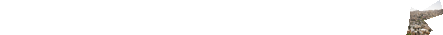
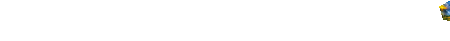
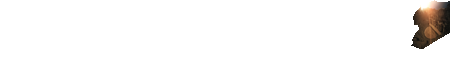
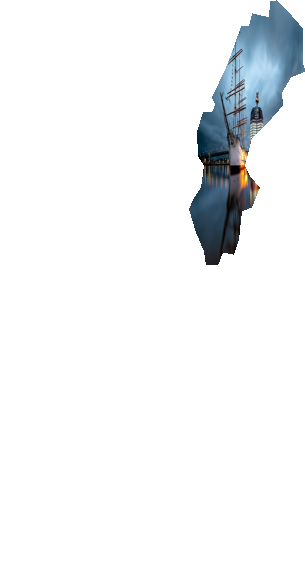
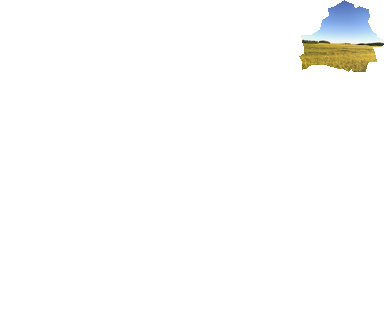
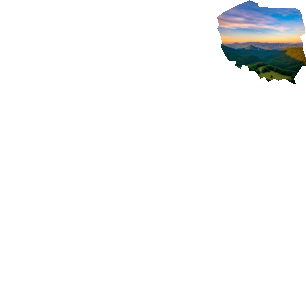
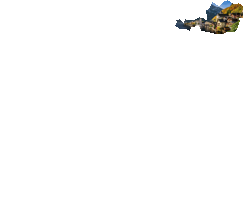
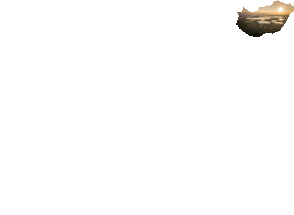
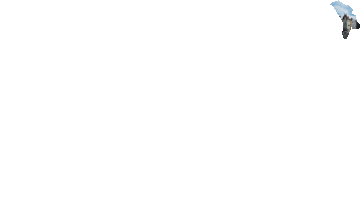
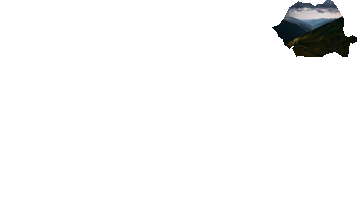
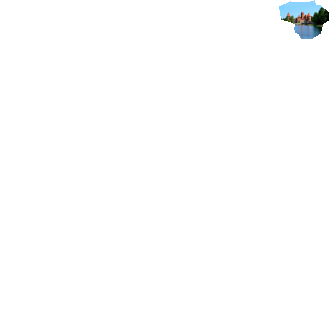
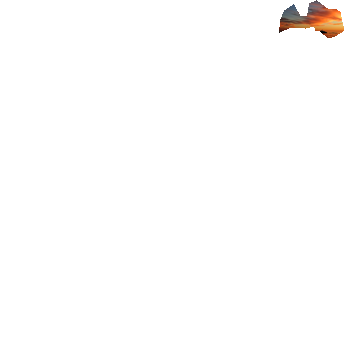
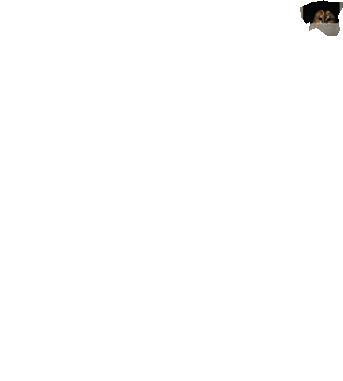
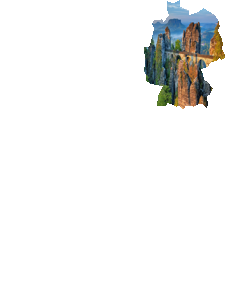
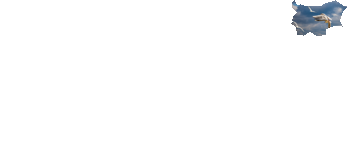
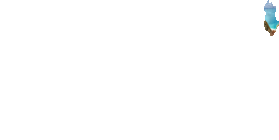
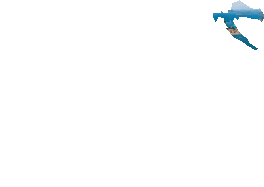
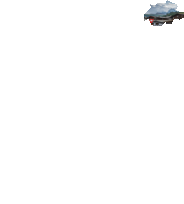
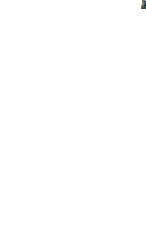
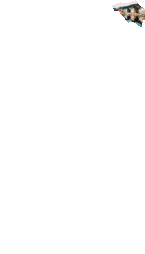
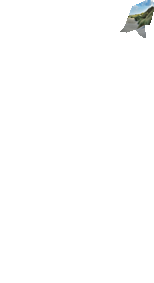
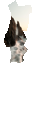
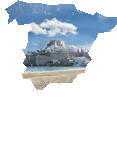
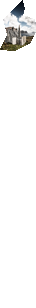
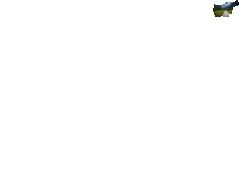
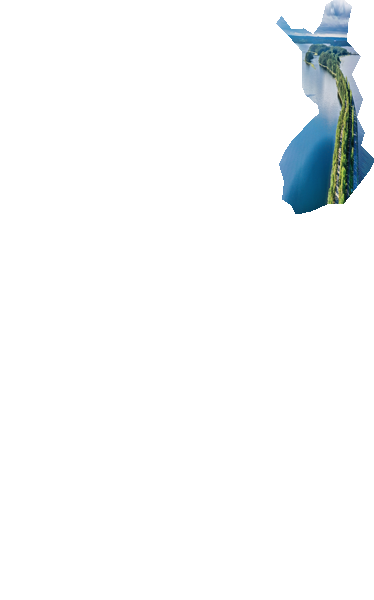
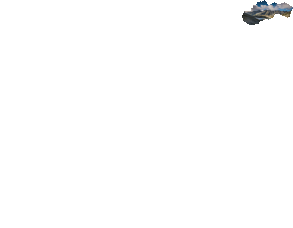
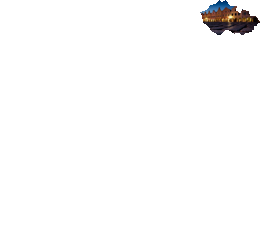
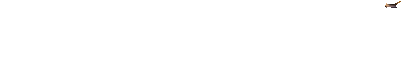
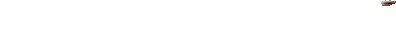
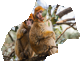
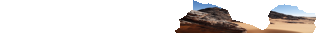
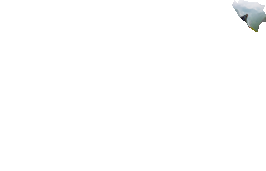
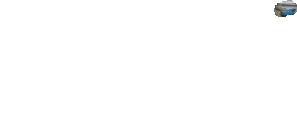
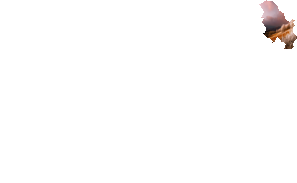
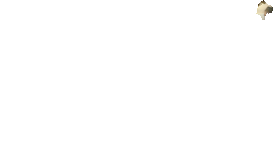
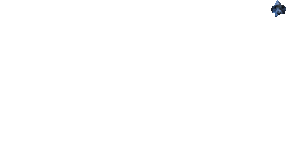
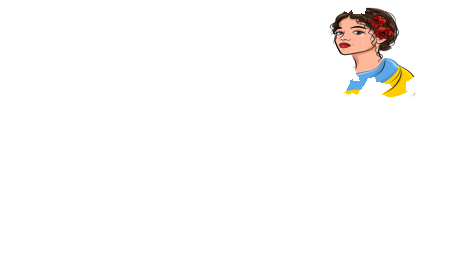

In [13]:
ggplot() + \
    geom_crop(aes(geometry='geometry', url='nature_img'), europe_gdf) + \
    geom_polygon(aes(x='x', y='y', group='name'), data=gdf_to_df(europe_gdf), \
                 color='black', size=1, alpha=0, tooltips=layer_tooltips().line('@name').color('black')) + \
    ggtitle('Nature in Europe') + \
    ggsize(width, height) + \
    theme(legend_position='none', axis_title='blank', axis_text='blank', axis_ticks='blank', axis_line='blank')

WARN: The function color() is deprecated and is no longer supported.



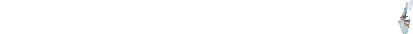
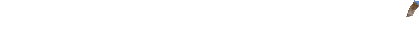
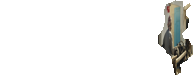
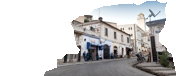
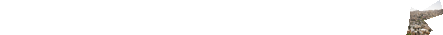
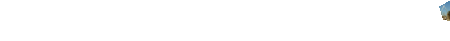
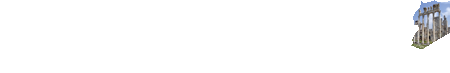
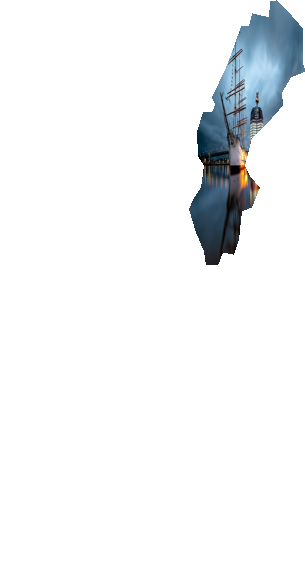
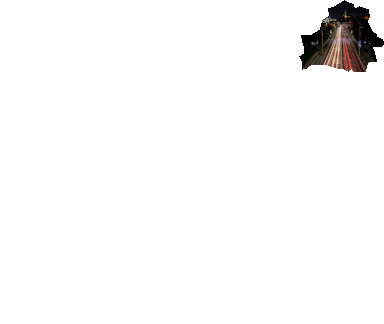
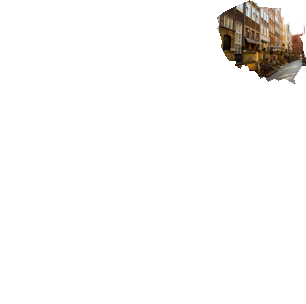
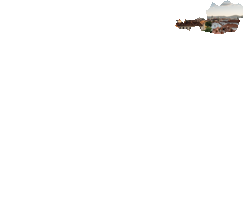
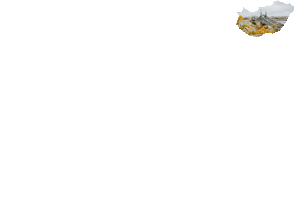
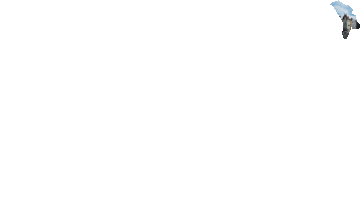
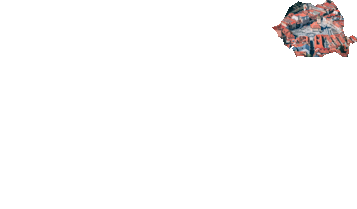
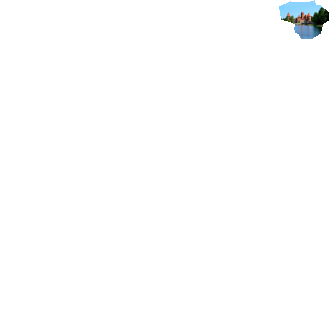
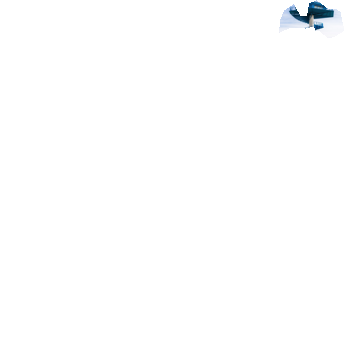
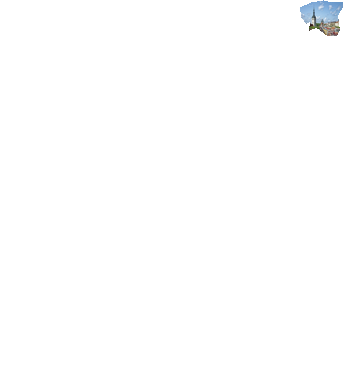
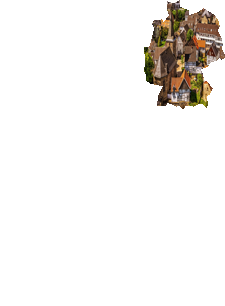
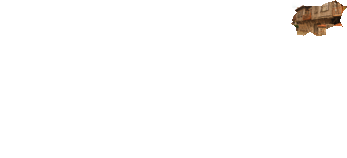
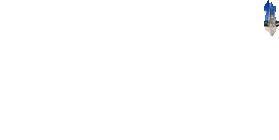
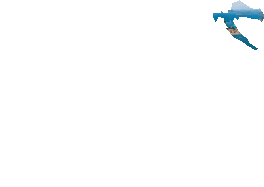
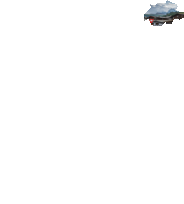
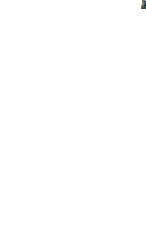
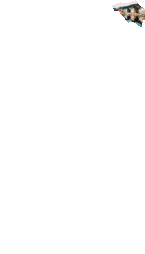
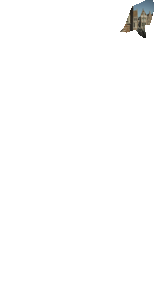
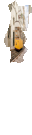
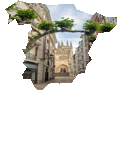
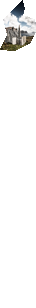
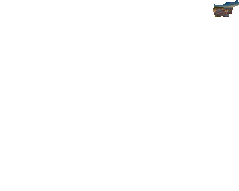
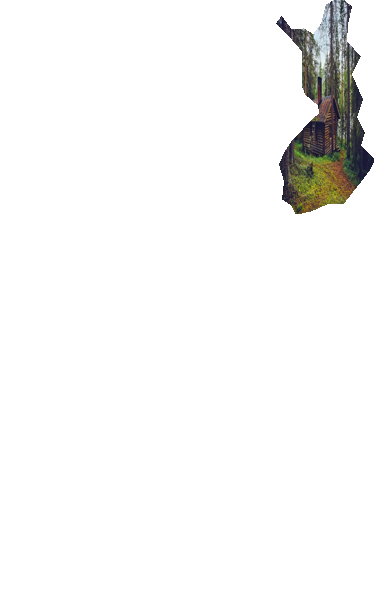
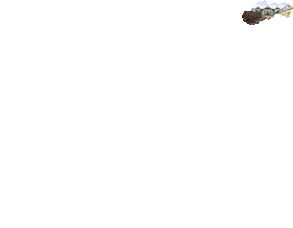
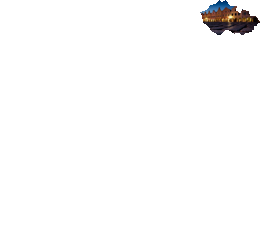
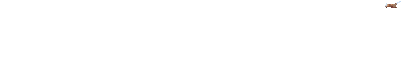
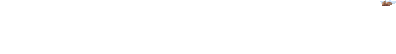
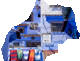

In [14]:
ggplot() + \
    geom_crop(aes(geometry='geometry', url='buildings_img'), europe_gdf) + \
    geom_polygon(aes(x='x', y='y', group='name'), data=gdf_to_df(europe_gdf), \
                 color='black', size=1, alpha=0, tooltips=layer_tooltips().line('@name').color('black')) + \
    ggtitle('Buildings in Europe') + \
    ggsize(width, height) + \
    theme(legend_position='none', axis_title='blank', axis_text='blank', axis_ticks='blank', axis_line='blank')